In [1]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

# data prepare

In [2]:
use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

In [3]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

==>>> total trainning batch number: 469
==>>> total testing batch number: 79


In [4]:
inputs, _ = next(iter(train_loader))
img = inputs[4][0]

import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray', interpolation='nearest')

# MODEL

In [5]:
class Encoder(nn.Module):

    def __init__(self, input_size = 28*28, output_size = 20):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc2_1 = nn.Linear(512, output_size)
        self.fc2_2 = nn.Linear(512, output_size)
        self.input_size = input_size
    
    def reparameterize(self, mu, var):
        std = torch.exp(0.5*var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.model(x.view(-1, self.input_size))
        mu = self.fc2_1(x)
        var = self.fc2_2(x)
        z = self.reparameterize(mu, var)
        return z  

    
class Decoder(nn.Module):

    def __init__(self, input_size = 20, output_size = 28*28):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, output_size),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        recon = self.model(z)
        return recon

    
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

# Training

In [24]:
#model parameter
latent_dim = 20

#training parameter
lrate = 0.001
epochs = 100

#models
E = Encoder(28*28, latent_dim)
De = Decoder(latent_dim, 28*28)
Di = Discriminator(latent_dim)
recon = nn.MSELoss()
criterion = nn.BCELoss()

if use_cuda:
    E = E.cuda()
    De = De.cuda()
    Di = Di.cuda()
    criterion = criterion.cuda()
    
optim_E = optim.Adam(E.parameters(), lr=lrate)
optim_De = optim.Adam(De.parameters(), lr=lrate)
optim_Di = optim.Adam(Di.parameters(), lr=lrate)

In [32]:
#training

for epoch in range(1, epochs):
    for batch_idx, (x, labels) in enumerate(train_loader):
        batch_size = x.size()[0]
        if use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        
        ################## Reconstruction #########################
        optim_E.zero_grad()
        optim_De.zero_grad()
        
        z = E(x)
        x_recon = De(z)
        loss_recon = recon(x_recon, x.view(-1, 784))
        loss_recon.backward()
        optim_E.step()
        optim_De.step()
        
        ################## Adversarial (regularization) ###########
        ####### train Discriminator
        optim_Di.zero_grad()
        z_real = Variable(torch.randn(batch_size, latent_dim) * 5.)
        y_real = Variable(torch.ones(batch_size))
        y_fake = Variable(torch.zeros(batch_size))
        if use_cuda:
            z_real = z_real.cuda()
            y_real = y_real.cuda()
            y_fake = y_fake.cuda()
        
        d_real = Di(z_real)
        z_fake = E(x)
        d_fake = Di(z_fake)
        
        loss_d_real = criterion(d_real, y_real)
        loss_d_fake = criterion(d_fake, y_fake)
        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optim_Di.step()
        ####### train Generator (Encoder)
        optim_E.zero_grad()
        y_real = Variable(torch.ones(batch_size))
        if use_cuda:
            y_real = y_real.cuda()

        z_fake = E(x)
        d_fake = Di(z_fake)
        
        loss_g = criterion(d_fake, y_real)
        loss_g.backward()
        optim_E.step()
        
        ####### print error
        if ((batch_idx+1) == len(train_loader)):
            print('==>>> epoch: {}, loss_recon: {:.6f}'.format(epoch,loss_recon.data))
            print('==>>> epoch: {}, loss_D: {:.6f}'.format(epoch,loss_d.data))
            print('==>>> epoch: {}, loss_G: {:.6f}'.format(epoch,loss_g.data))

print("===================Finished!=================== ")

==>>> epoch: 1, loss_recon: 0.878797
==>>> epoch: 1, loss_D: 1.383974
==>>> epoch: 1, loss_G: 0.742400
==>>> epoch: 2, loss_recon: 0.871885
==>>> epoch: 2, loss_D: 1.396563
==>>> epoch: 2, loss_G: 0.669667
==>>> epoch: 3, loss_recon: 0.881688
==>>> epoch: 3, loss_D: 1.370881
==>>> epoch: 3, loss_G: 0.650627
==>>> epoch: 4, loss_recon: 0.870628
==>>> epoch: 4, loss_D: 1.383299
==>>> epoch: 4, loss_G: 0.638724
==>>> epoch: 5, loss_recon: 0.877731
==>>> epoch: 5, loss_D: 1.392958
==>>> epoch: 5, loss_G: 0.689351
==>>> epoch: 6, loss_recon: 0.879601
==>>> epoch: 6, loss_D: 1.366720
==>>> epoch: 6, loss_G: 0.708317
==>>> epoch: 7, loss_recon: 0.873963
==>>> epoch: 7, loss_D: 1.372800
==>>> epoch: 7, loss_G: 0.709837
==>>> epoch: 8, loss_recon: 0.873883
==>>> epoch: 8, loss_D: 1.415189
==>>> epoch: 8, loss_G: 0.695010
==>>> epoch: 9, loss_recon: 0.872908
==>>> epoch: 9, loss_D: 1.381383
==>>> epoch: 9, loss_G: 0.639099
==>>> epoch: 10, loss_recon: 0.879890
==>>> epoch: 10, loss_D: 1.380201
=

==>>> epoch: 78, loss_D: 1.382612
==>>> epoch: 78, loss_G: 0.674750
==>>> epoch: 79, loss_recon: 0.868738
==>>> epoch: 79, loss_D: 1.382632
==>>> epoch: 79, loss_G: 0.681827
==>>> epoch: 80, loss_recon: 0.869097
==>>> epoch: 80, loss_D: 1.377984
==>>> epoch: 80, loss_G: 0.678862
==>>> epoch: 81, loss_recon: 0.867820
==>>> epoch: 81, loss_D: 1.380641
==>>> epoch: 81, loss_G: 0.826745
==>>> epoch: 82, loss_recon: 0.866285
==>>> epoch: 82, loss_D: 1.391109
==>>> epoch: 82, loss_G: 0.728385
==>>> epoch: 83, loss_recon: 0.874236
==>>> epoch: 83, loss_D: 1.384263
==>>> epoch: 83, loss_G: 0.703822
==>>> epoch: 84, loss_recon: 0.873542
==>>> epoch: 84, loss_D: 1.376665
==>>> epoch: 84, loss_G: 0.689441
==>>> epoch: 85, loss_recon: 0.872152
==>>> epoch: 85, loss_D: 1.373987
==>>> epoch: 85, loss_G: 0.682735
==>>> epoch: 86, loss_recon: 0.872266
==>>> epoch: 86, loss_D: 1.377291
==>>> epoch: 86, loss_G: 0.723996
==>>> epoch: 87, loss_recon: 0.870857
==>>> epoch: 87, loss_D: 1.395457
==>>> epoch:

# Fake image

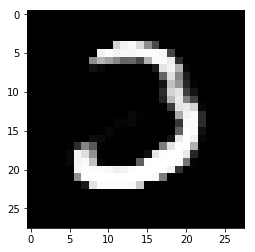

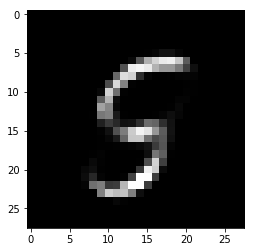

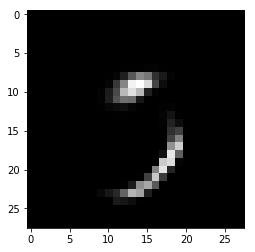

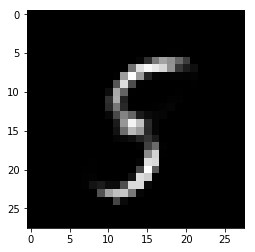

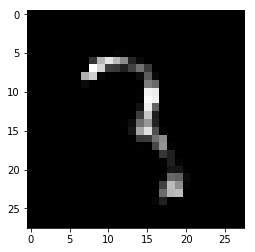

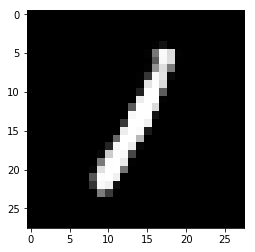

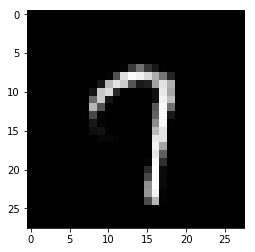

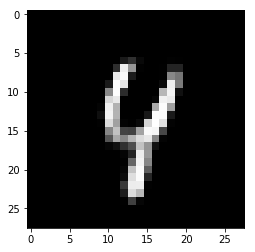

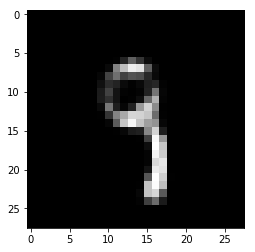

In [33]:
z = Variable(torch.randn(batch_size, latent_dim) * 5.).cuda()
model = De
fake_img = model(z)

import matplotlib.pyplot as plt
for i in range(1, 10):
    img = fake_img[i].cpu().detach().numpy()
    img = img.reshape(28, 28)
    plt.figure()
    plt.imshow(img, cmap='gray', interpolation='nearest')

# Recon img

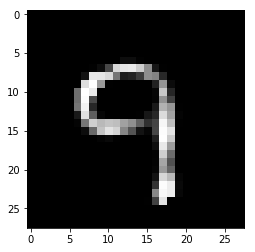

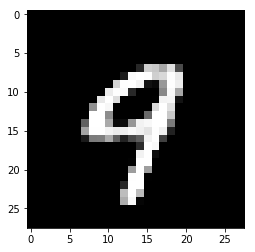

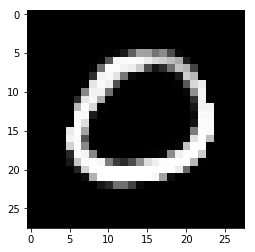

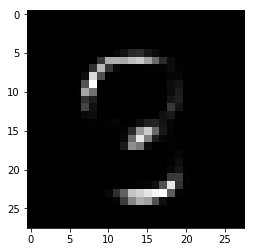

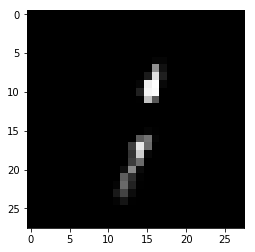

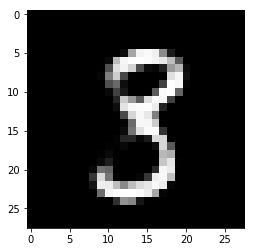

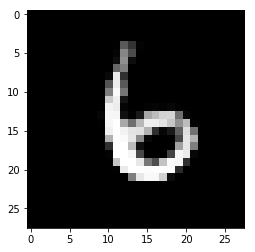

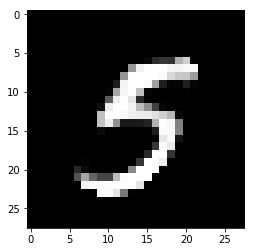

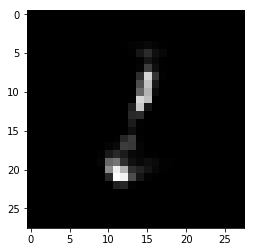

In [34]:
inputs, _ = next(iter(train_loader))
inputs = inputs[0:10].cuda()
z = E(inputs)
recon_img = De(z)

for i in range(1, 10):
    img = recon_img[i].cpu().detach().numpy()
    img = img.reshape(28, 28)
    plt.figure()
    plt.imshow(img, cmap='gray', interpolation='nearest')